if x is d-dimensional we can consider:

$log p_{\theta}(x) = \sum_{i=1}^{d}p_{\theta}(x_{i}|parents(x_{i}))$ <br>

It is not a big simplification, because for each joint distribution we can write: <br><br>
$log p(x) = \sum_{i=1}^{d}p(x_{i}|x_{1:i-1})$ <br>

When we decompose distribution p in our model we call our model: $\textbf{autoregressive model}$

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x2, x1], axis=-1)

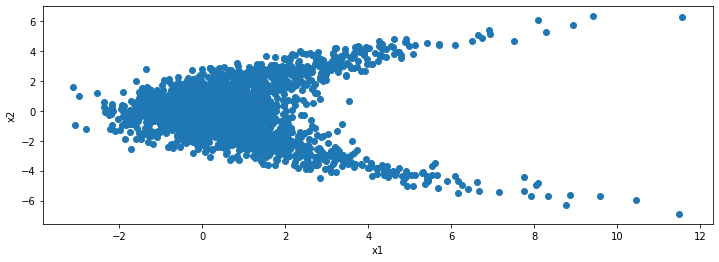

In [3]:
plt.subplots(figsize=(12, 4))
plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2');

In [4]:
base_distribution = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2])

In [5]:
sampled_data = base_distribution.sample(5000)
sampled_x1 = sampled_data[:, 0]
sampled_x2 = sampled_data[:, 1]

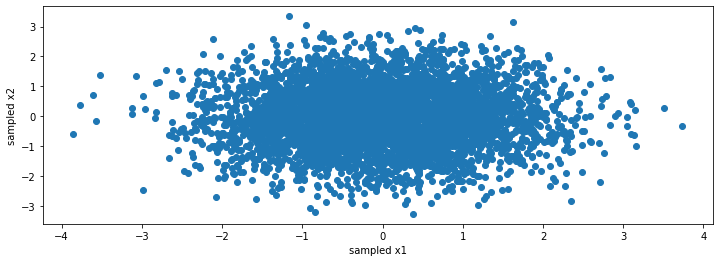

In [6]:
plt.subplots(figsize=(12, 4))
plt.scatter(sampled_x1, sampled_x2)
plt.xlabel('sampled x1')
plt.ylabel('sampled x2');

In [7]:
def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(
        params=2, 
        hidden_units=hidden_units,
        activation=activation,
        event_shape=2
    )
    
    return tfb.MaskedAutoregressiveFlow(made)

In [8]:
trainable_distribution = tfd.TransformedDistribution(
    base_distribution,
    make_masked_autoregressive_flow()
)

In [9]:
trainable_distribution

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [10]:
def train(trainable_distribution, epochs=200, batch_size=None, n_disp=100):
    x = tfkl.Input(shape=(2,), dtype=tf.float32)
    log_prob = trainable_distribution.log_prob(x)
    model = tfk.Model(x, log_prob)
    
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss=lambda _, log_prob_: -log_prob_,
    )
    
    epoch_callback = tfk.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )

    history = model.fit(
        x=data,
        y=np.zeros((n, 0), dtype=np.float32),
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        shuffle=True,
        verbose=False,
        callbacks=[epoch_callback]
    )
    
    return history

In [11]:
history = train(trainable_distribution, epochs=600, batch_size=None, n_disp=50)


 Epoch 1/600 
	 loss: 5.5173, val_loss: 4.9979

 Epoch 51/600 
	 loss: 3.5435, val_loss: 3.5682

 Epoch 101/600 
	 loss: 3.5376, val_loss: 3.5650

 Epoch 151/600 
	 loss: 3.5360, val_loss: 3.5669

 Epoch 201/600 
	 loss: 3.5355, val_loss: 3.5723

 Epoch 251/600 
	 loss: 3.5346, val_loss: 3.5714

 Epoch 301/600 
	 loss: 3.5351, val_loss: 3.5686

 Epoch 351/600 
	 loss: 3.5350, val_loss: 3.5659

 Epoch 401/600 
	 loss: 3.5339, val_loss: 3.5709

 Epoch 451/600 
	 loss: 3.5335, val_loss: 3.5657

 Epoch 501/600 
	 loss: 3.5341, val_loss: 3.5710

 Epoch 551/600 
	 loss: 3.5343, val_loss: 3.5644


In [12]:
sampled_data = trainable_distribution.sample(5000)
sampled_x1 = sampled_data[:, 0]
sampled_x2 = sampled_data[:, 1]

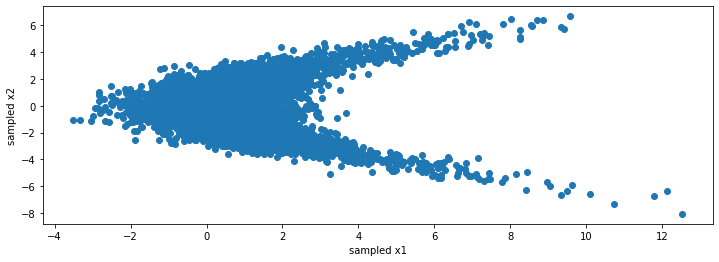

In [13]:
plt.subplots(figsize=(12, 4))
plt.scatter(sampled_x2, sampled_x1)
plt.xlabel('sampled x1')
plt.ylabel('sampled x2');